# MNIST Handwritten Digit Classifier
This notebooks is meant to introduce you to using Keras and Tensorflow to create and train neural networks for handwritten digit classification.

Additional resources:
- **3Blue1Brown**, the YouTube channel, has produced an _**excellent**_ video series explaining neural networks ituitively. He also goes into some of the math behind why these neural networks work. [Part 1](https://www.youtube.com/watch?v=aircAruvnKk), [Part 2](https://www.youtube.com/watch?v=IHZwWFHWa-w), [Part 3](https://www.youtube.com/watch?v=Ilg3gGewQ5U), [Part 3.a](https://www.youtube.com/watch?v=tIeHLnjs5U8). 
- **Welch Labs**, another YouTube channel, produced a 15 part series on computer vision and machine learning called **Learning to See**: [Playlist](https://www.youtube.com/watch?v=i8D90DkCLhI&list=PLiaHhY2iBX9ihLasvE8BKnS2Xg8AhY6iV)

## Neural Networks

Neural Networks are a machine learning technique modeled after the human brain, hence the term **neural**. They are inspired by the fact that our brains consist of **neurons** that **activate** when responding to stimuli. What is important though is that the neurons activate *differently* to different stimuli. For example, a group of neurons in your brain will light up in a similar manner whenever you view the number 1. It doesn't matter if the number is written by hand or by a computer, there is a section of our brain that has learned what the number 1 looks like. There is **another** area of the brain that is activated when you look at the number 7. In other words, we receive as **input** a number, a group of **neurons** **activate** in response to that input, and we receive an **output**, a thought of what the number is.

Back in **1957** (really old!), some scientists decided to apply these biologically inspired ideas to computers in an effort to allow a computer to **learn** and recognize images. This was the **Mark 1 Perceptron**, shown below.

![Mark 1 Perceptron](https://upload.wikimedia.org/wikipedia/en/5/52/Mark_I_perceptron.jpeg)

The Mark 1 Perceptron consisted of a large number of connections between the **input**, a camera, and the **output**, an electrical signal. Between the **input** and the **output** were knobs and dials that changed how **active** all of the connections were. The idea was to show the camera on the Perceptron an image then to twist the knobs and dials until we received the output we wanted. When we have gotten the correct output for each of the input images, by twisting all of the knobs and dials sufficiently, we will have taught this machine that when given an **input**, it should **activate** its **neurons** in some way to produce the correct **output**.

This all led to the more recent development of **Artifical Neural Networks**, shown below.

![Artifical Neural Network](https://cdn-images-1.medium.com/max/1600/0*IUWJ5oJ_z6AiG7Ja.jpg)

Artificial Neural Networks take the concept of the brain onto a digital computer. There are three important components: the **input layer**, which is where we put our input data into the system, the **hidden layer**, which is where all of our **neurons** (**knobs** and **dials**) exist, and the **output layer**. To train the neural network, we follow a 3 step process:

1. Give the neural network an input
2. Compare the output to what I expect
3. Change the knobs and dials so that the next time I show the input, it will produce a better output

If we want to teach a neural network to recognize handwritten digits, the first thing we do is collect a set of **training data**, a set of handwritten digit images and a **label** which says what type of digit is in the image. For example we might have the following **image** and **label** pair:


<center> <img src="http://joshmontague.com/images/mnist-2.png" alt="The number 2" style="width: 100px;"/> **Label**:  2 </center>

We then match up each **pixel** of the image with each **input** node in the neural network. Our **output** layer will be **10** nodes, corresponding to how confident we are that the **input** image is one of the ten digit types: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9. We then compare what the model predicts to the number we know that is in the image. Because we make this direct comparison between our neural network's prediction and the digit in the image, neural networks are known as a **supervised learning** method. The hope is that if we input all of the **pixels** of an image into the network, it will produce a **high activation** at the output layer only for the **correct** number in the image. For example, we would hope that if we input the image above, we might get an output like: \[0, 0, 1, 0, 0, 0, 0, 0, 0, 0\]. This has **high activation** only for the **2nd node** in the output layer and **no activation** for the rest of the nodes. If this is the case, our network has correctly predicted that the image contains a 2! In reality, each of the numbers in the output layer won't be 0 or 1, but rather something in between. To get the predicted label, we simply take the **index** of the **maximum** value in our list. For example, for the image of the 2 as input we might get the output: \[0.02, 0.10, 0.98, 0.05, 0.03, 0.01, 0.12, 0.08, 0.09, 0.11\]. The corresponding **prediction** is still 2 since that node in the output layer has the **highest activation**.

In [1]:
import tensorflow
import keras
from keras.datasets import mnist
from keras.optimizers import RMSprop
from keras.models import Sequential, load_model
from keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

Using TensorFlow backend.


### Helper Function

We define a few helper functions to let us examine our data.
```python
def show_numbers(numbers, labels)
```
Takes as input a few black and white images of our numbers, called `numbers`, and their labels, called `labels`, and produces pictures of them for us.

In [2]:
def show_numbers(numbers, labels):
    # If our image is flattened already, then make it a square again
    if len(numbers[0]) == 784:
        numbers = np.asarray(numbers).reshape(len(numbers), 28, 28)
    # If our labels are vectorized already, let's get them back to a list of numbers
    if type(labels[0]) == np.ndarray:
        labels = np.argmax(labels, axis=1)

    for number, label in zip(numbers, labels):
        # Plot the number using a gray color scheme.
        plt.imshow(number, cmap='gray')
        # Provide a title - the label for the number image
        plt.title("This is a {}".format(label))
        # Remove the axis tics
        plt.axis('off')
        # Make the font of the plot bigger
        plt.rc('axes', titlesize=16)
        # Show the image!
        plt.show()

In [3]:
def get_random_images_and_labels(images, labels, num_to_get):
    indices = np.arange(len(images))

    random_indices = np.random.choice(indices, num_to_get)

    random_images = images[random_indices]
    corresponding_labels = labels[random_indices]
    
    return random_images, corresponding_labels

## Loading the data
The MNIST dataset is a collection of grayscale handwritten digits which is a commonly used dataset in machine learning. The MNIST data is split into **training data** and **testing data**. **Training data** are digit images used to **train** the neural network classifier. **Testing data** is a **separate** set of digit images used to **test** the neural network classifier. By holding aside a set of handwritten digits in a test set, we are able to see how our classifier is expected to perform on unseen data.

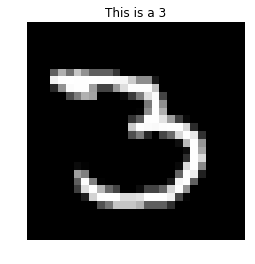

In [4]:
# Load the data and split it into training and testing data
train_data, test_data = mnist.load_data()

# Split up the training and testing data into their corresponding 
number_images, number_labels = train_data
x_test, y_test = test_data

# Let's see what the data actually looks like
num_images_to_show = 1

random_images, corresponding_labels = get_random_images_and_labels(number_images, number_labels, num_images_to_show)

show_numbers(random_images, corresponding_labels)

## Preprocess Data
We need to process our images a little bit so that we can properly link up each **pixel** of the image to the **input layer** of the neural network.

```python
def pre_process_data(numbers)
```
Is a function that takes as input the images of our numbers, called `numbers`, and produces as output images of the same numbers that are slightly different in a few ways. First, our input images are $28\times28$ pixels (squares). We want however to attach each pixel to 1 input neuron in our neural network. This means we have to **flatten** our images from squares to lines. We do this using the line:
```python
numbers = numbers.reshape(len(numbers), 784)
```
The brightness of each pixel is actually encoded with an **integer** from 0 to 255, where 0 means black and 255 means white. What we want however is for our pixel brightnesses to be represented by a **real** number from 0 to 1, where 0 means black and 1 means white. Both of these steps is done with the two lines:
```python
numbers = numbers.astype('float32')
numbers = numbers / 255.
```

In [5]:
def pre_process_data(numbers):
    # Flatten out each of the number images so that are 1 dimensional array
    numbers = numbers.reshape(len(numbers), 784)
    numbers = numbers.astype('float32')
    numbers = numbers / 255.
    return numbers

In [6]:
x_train = pre_process_data(number_images)
x_test = pre_process_data(x_test)

We also need to change our labels so that they are similar to the **output layer** of the neural network. Our network produces a **list** of 10 numbers which correspond to our network's confidence about the classification of each image. To compare the output of our network to our labels, we will convert each label (a single number e.g. 2) to a list that contains **activation** only for the node that corresponds to a 2 in the ouput layer.
```python
def pre_process_labels(labels, number_of_labels=10)
```
Is a function that takes as input our labels, called `labels`, along with the number of labels, called `number_of_labels` (who's default value is 10), and produces as output labels which have been converted to a **one-hot vector**. For example, the number 2 is converted to a list of 10 numbers, all 0 except for the *third* number (remember we start counting at 0) which is a 1: 2 $\rightarrow \left[0, 0, 1, 0, 0, 0, 0, 0, 0, 0\right]$.

This is all done using the line:
```python
new_labels = keras.utils.to_categorical(labels, number_of_labels)
```

In [7]:
def pre_process_labels(labels, number_of_labels=10):
    new_labels = keras.utils.to_categorical(labels, number_of_labels)
    return new_labels

In [8]:
y_train = pre_process_labels(number_labels)
y_test = pre_process_labels(y_test)

## Create the Neural Network
The network we create has an **input layer** which has **784 nodes**, one for each pixel in the input image. We then have two **hidden layers** each with 256 nodes. This gives us a large number of knobs and dials (269,322 of them!) to tune our network with. We then have an **output layer** with 10 nodes, with each node corresponding to one of our digits.

In [9]:
# Here, we build the network
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(784,)))
model.add(Dense(256, activation='relu', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))

# We need some way to determine how far our network's guess is from the correct answer
loss_type = 'mean_squared_error'
model.compile(loss=loss_type, optimizer=RMSprop(), metrics=['accuracy'])

# Print out what our network looks like
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 269,322.0
Trainable params: 269,322
Non-trainable params: 0.0
_________________________________________________________________


## Train the Neural Network
Finally, we can train the network by repeatedly showing the network a set of **128** images (our **batch size**) selected from our **training data**. We see what output is produced by the network for each of these images and compare them to the provided **labels**. We can get improved performance by going through the training data a few times (the number of **epochs**).

In [10]:
batch_size = 128
epochs = 7

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=True, validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

Train on 60000 samples, validate on 10000 samples
Epoch 1/7
60000/60000 [==============================] - 6s - loss: 0.0122 - acc: 0.9195 - val_loss: 0.0057 - val_acc: 0.9624
Epoch 2/7
60000/60000 [==============================] - 5s - loss: 0.0053 - acc: 0.9659 - val_loss: 0.0046 - val_acc: 0.9698
Epoch 3/7
60000/60000 [==============================] - 6s - loss: 0.0036 - acc: 0.9769 - val_loss: 0.0046 - val_acc: 0.9688
Epoch 4/7
60000/60000 [==============================] - 5s - loss: 0.0029 - acc: 0.9817 - val_loss: 0.0035 - val_acc: 0.9773
Epoch 5/7
60000/60000 [==============================] - 5s - loss: 0.0023 - acc: 0.9856 - val_loss: 0.0043 - val_acc: 0.9726
Epoch 6/7
60000/60000 [==============================] - 5s - loss: 0.0019 - acc: 0.9880 - val_loss: 0.0032 - val_acc: 0.9800
Epoch 7/7
60000/60000 [==============================] - 6s - loss: 0.0016 - acc: 0.9897 - val_loss: 0.0033 - val_acc: 0.9798


## Let's see what we get!
Now we can use our model to make predictions given an **unseen input** image.
```python
def get_predictions(test_data, model)
```
Is a function that takes as input the images we want to classify, called `test_data`, along with a trained neural network which will do the classification, called `model`. The line 
```python
model_predictions = model.predict(test_data)
``` 
returns a **vector** of values, similar to our labels. The *index* of the entry in the list with the largest value is our prediction for how to classify our new image! We find these indices using the line
```python
number_predictions = np.argmax(model_predictions, axis=1)
```
where `np.argmax` finds us the **argument** or the **index** with **maximum** value for each of our prediction lists.

In [11]:
def get_predictions(test_data, model):
    model_predictions = model.predict(test_data)
    number_predictions = np.argmax(model_predictions, axis=1)
    return number_predictions

In [12]:
model_predictions = get_predictions(x_test, model)
print(model_predictions)

[7 2 1 ..., 4 5 6]


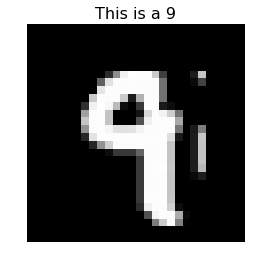

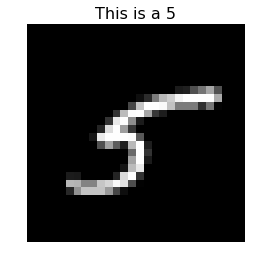

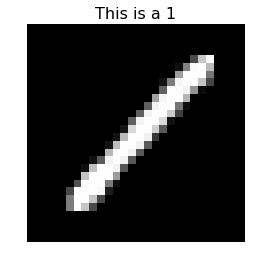

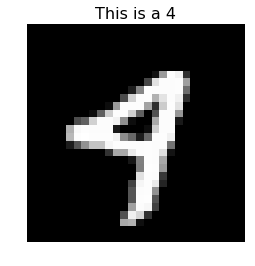

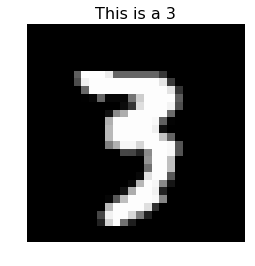

In [13]:
# Let's see what labels our model predicts for different inputs
num_images_to_show = 5

random_images, corresponding_labels = get_random_images_and_labels(x_test, y_test, num_images_to_show)

show_numbers(random_images, corresponding_labels)

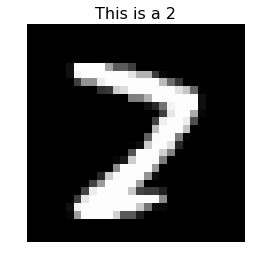

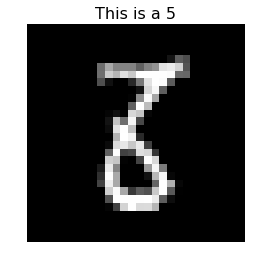

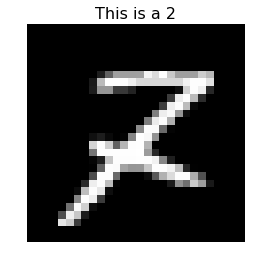

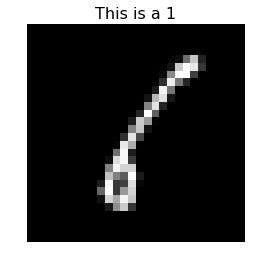

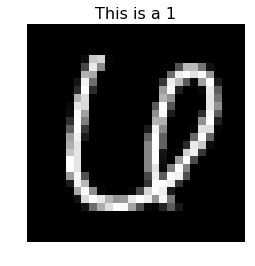

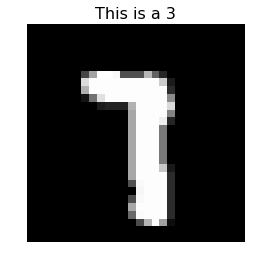

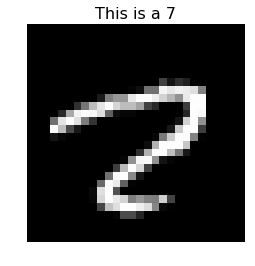

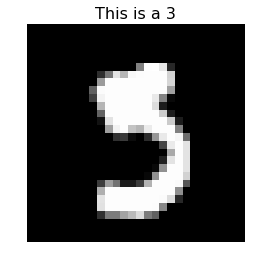

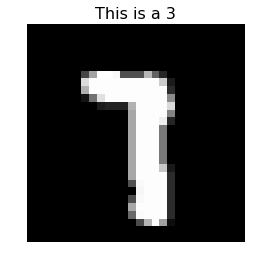

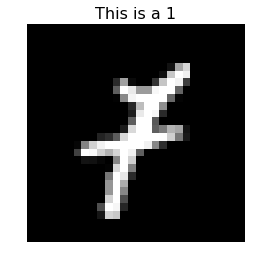

In [14]:
model_predictions = get_predictions(x_test, model)
wrong_numbers = np.where(np.not_equal(model_predictions, np.argmax(y_test, axis=1)))
incorrect_images = x_test[wrong_numbers]
incorrect_labels = model_predictions[wrong_numbers]

num_images_to_show = 10

random_images, corresponding_labels = get_random_images_and_labels(incorrect_images, incorrect_labels, num_images_to_show)

show_numbers(random_images, corresponding_labels)